# <center> Практика. EDA + Feature Engineering. Соревнование на Kaggle </center>

### **Постановка задачи:**

**ИССЛЕДОВАНИЕ ДАННЫХ:**

✍ В этом модуле мы будем работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую мы будем обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.

***ДАННЫЕ САЙТА BOOKING:***

Наименование столбца:  | Описание столбца:
------- | --------
***hotel_address***   | адрес отеля;
***review_date***   | дата, когда рецензент разместил соответствующий отзыв;
***average_score***   | средний балл отеля, рассчитанный на основе последнего комментария за последний год;
***hotel_name***   | название отеля;
***reviewer_nationality***   | страна рецензента;
***negative_review***   | отрицательный отзыв, который рецензент дал отелю;
***review_total_negative_word_counts***   | общее количество слов в отрицательном отзыв;
***positive_review***   | положительный отзыв, который рецензент дал отелю;
***review_total_positive_word_counts***   | общее количество слов в положительном отзыве.
***reviewer_score***   | оценка, которую рецензент поставил отелю на основе своего опыта;
***total_number_of_reviews_reviewer_has_given***   | количество отзывов, которые рецензенты дали в прошлом;
***total_number_of_reviews***   | общее количество действительных отзывов об отеле;
***tags***   | теги, которые рецензент дал отелю;
***days_since_review***   | количество дней между датой проверки и датой очистки;
***additional_number_of_scoring***   | есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
***lat***   | географическая широта отеля;
***lng***   | географическая долгота отеля.

***Содержание работы:***

1. Импорт библиотек и загрузка данных.
2. Очистка данных.
3. Исследование данных.Генерация и преобразование признаковнаковв.
6. Отбор приз6аков.
7. Обучение модели.

## **1. Импорт библиотек и загрузка данных:**

In [1]:
# Загружаем необходимые библиотеки:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем
# трейн и тест в один датасет:

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score,
# мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)
# объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lng'}>,
        <AxesSubplot:title={'center':'sample'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

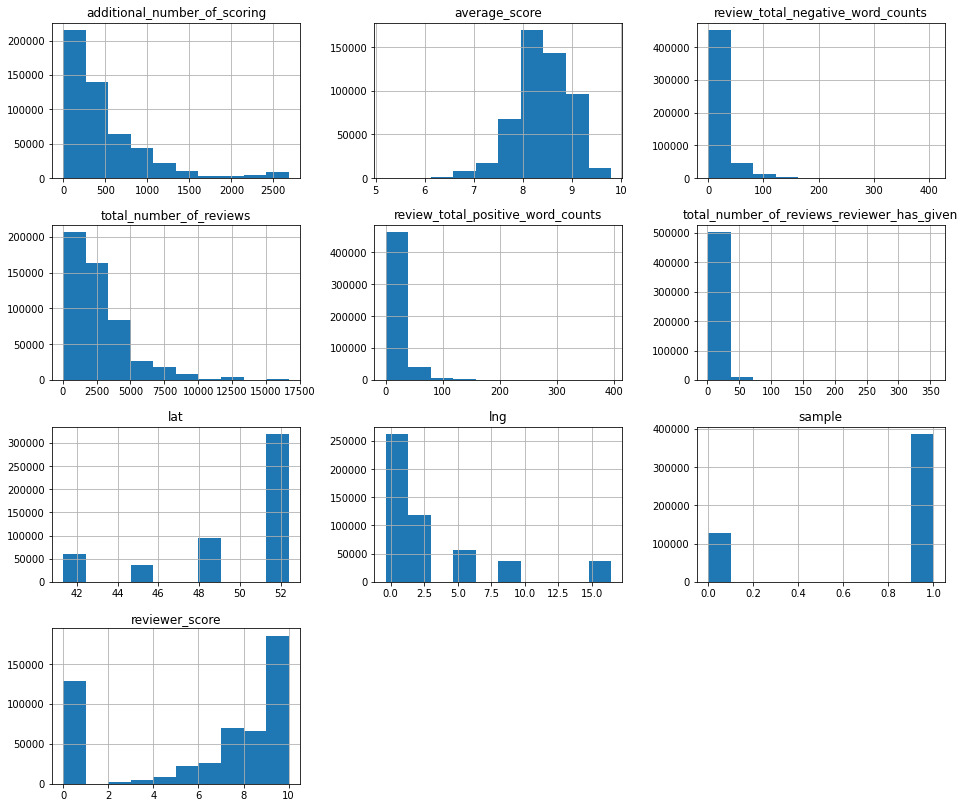

In [13]:
# Распределение числовых признаков:

data.hist(figsize = (16,14))

In [14]:
data['lat'] = data['lat'].fillna(0, inplace=True)
data['lng'] = data['lng'].fillna(0, inplace=True)

In [15]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                                1
lng                                                1
sample                                             2
reviewer_score                                    38
dtype: int64

<AxesSubplot:>

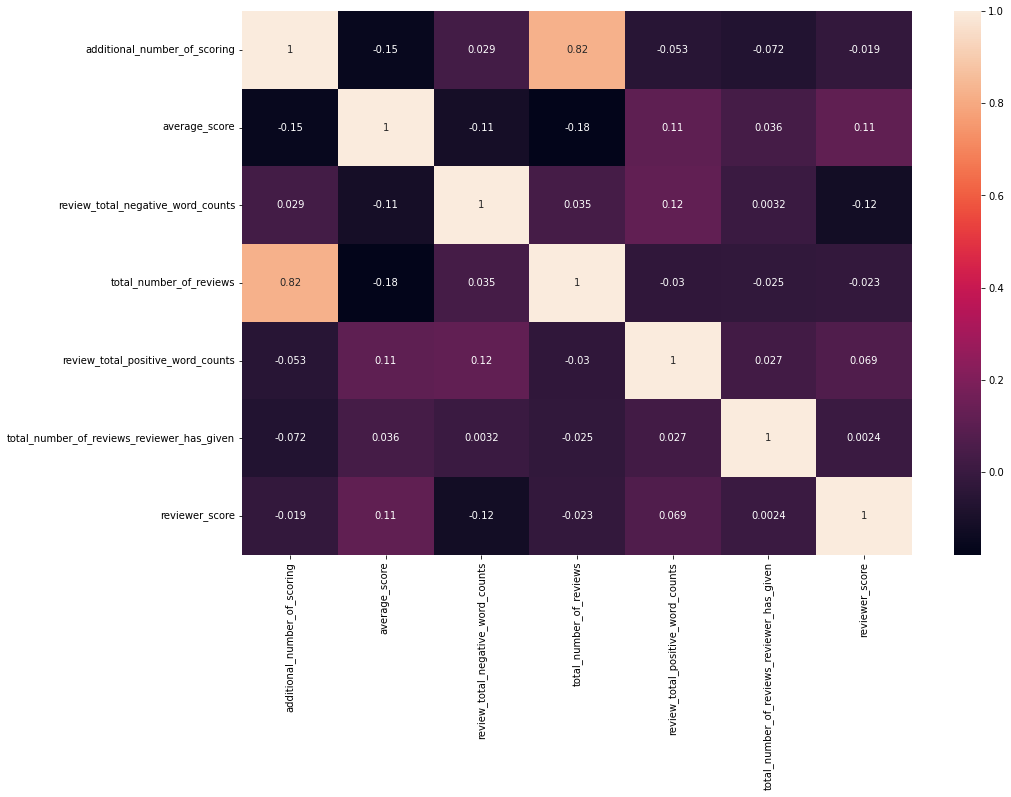

In [16]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

### ***Вывод:*** в датасете 515738 записей (есть пропущенные значения).

## **2. Очистка данных:**

2.1. Проверим данные на наличие дубликатов и удалим найденные дубликаты:

In [17]:
print('В датасете в тренировочной выборке: {} дубликатов.'.format(df_train[df_train.duplicated()].shape[0]))
print('В датасете в тестовой выборке: {} дубликатов.'.format(df_test[df_test.duplicated()].shape[0]))

df_train.drop_duplicates(inplace=True)
print('Количество строк после удаления дубликатов в тренировочной выборке составляет: {}.'.format(df_train.shape[0]))

В датасете в тренировочной выборке: 307 дубликатов.
В датасете в тестовой выборке: 29 дубликатов.
Количество строк после удаления дубликатов в тренировочной выборке составляет: 386496.


### ***Вывод:*** найдены дубликаты в обеих частях датасета мы проведем удаление дубликатов, только в тренировочной выборке (представленные данные содержат 307 дубликатов), т.к. тестовая выборка фиксирована и ее изменять нельзя по правилам соревнования на kaggle. Количество строк после удаления дубликатов в тренировочной выборке составляет 386496.

## **3. Исследование данных:**

3.1. Классифицируем все признаки на числовые и категориальные:

***Категориальные признаки:***
1. hotel_address
2. review_date
3. hotel_name
4. reviewer_nationality
5. negative_review
6. positive_review
7. tags
8. days_since_review

***Числовые признаки:***
1. additional_number_of_scoring
2. average_score
3. review_total_negative_word_counts
4. total_number_of_reviews
5. review_total_positive_word_counts
6. total_number_of_reviews_reviewer_has_given
7. lat
8. lng
9. sample
10. reviewer_score

3.2. Выведем на экран основные статистические характеристики
данных по каждому числовому признаку:

In [18]:
data.describe(include = 'all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
count,515738,515738.000000,515738,515738.000000,515738,515738,515738,515738.000000,515738.000000,515738,515738.000000,515738.000000,515738,515738,0,0,515738.000000,515738.000000
unique,1493,NaN,731,NaN,1492,227,330011,NaN,NaN,412601,NaN,NaN,55242,731,0,0,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN,NaN,NaN
freq,4789,NaN,2585,NaN,4789,245246,127890,NaN,NaN,35946,NaN,NaN,5101,2585,NaN,NaN,NaN,NaN
mean,NaN,498.081836,NaN,8.397487,NaN,NaN,NaN,18.539450,2743.743944,NaN,17.776458,7.166001,NaN,NaN,NaN,NaN,0.749999,6.297672
std,NaN,500.538467,NaN,0.548048,NaN,NaN,NaN,29.690831,2317.464868,NaN,21.804185,11.040228,NaN,NaN,NaN,NaN,0.433014,3.902295
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.000000,NaN,NaN,NaN,NaN,0.250000,0.625000
50%,NaN,341.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.000000,NaN,NaN,NaN,NaN,1.000000,7.900000
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,22.000000,8.000000,NaN,NaN,NaN,NaN,1.000000,9.600000


### **Вывод:** с помощью метода describe() определили основные статистические характеристики для каждого из признаков.

## **4. Генерация и преобразование признаков:**

4.1. Иследуем признак hotel_address и создадим новые признаки ***'country'*** - страна, ***'city'*** - город, ***'hotel_city_count'*** - количество отелей в городе:

In [19]:
# Создание нового признака 'country':

data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1] 
        if x.split()[-1] != 'Kingdom' 
        else ' '.join(x.split()[-2:]))

print('\n В датасете представлены отели из '+ str(
    data['country'].nunique()) + ' стран:\n')
print(data['country'].value_counts())


 В датасете представлены отели из 6 стран:

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64


In [20]:
# Создание нового признака 'city':

data['city'] = data.apply(lambda x: x['hotel_address'].split()[-5] 
        if x['country'] == 'United Kingdom'
        else x['hotel_address'].split()[-2], axis=1)

print('\n В датасете представлены отели из '+ str(
    data['city'].nunique()) + ' городов:\n')
print(data['city'].value_counts())


 В датасете представлены отели из 6 городов:

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64


In [21]:
# Создание нового числового признака 'hotel_city_count':

data['hotel_city_count'] = data.groupby(
    'city')['hotel_name'].transform('count')

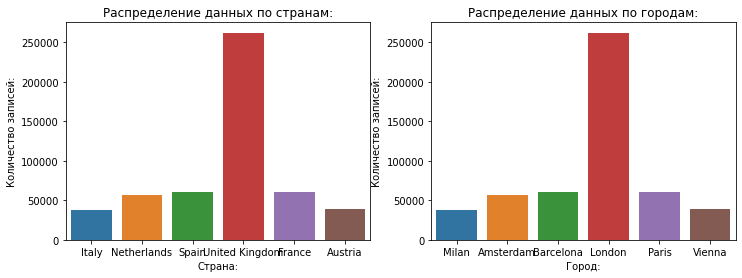

In [22]:
# Построим график:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.countplot(data['country'], ax=axes[0]);
axes[0].set(xlabel='Страна:', ylabel='Количество записей:')
axes[0].set_title('Распределение данных по странам:')

sns.countplot(data['city'],  ax=axes[1]);
axes[1].set(xlabel='Город:', ylabel='Количество записей:')
axes[1].set_title('Распределение данных по городам:')
fig.show()

In [23]:
# Кодируем признаки методом OneHotEncoding:

data = pd.get_dummies(data, columns = ['country'])
data = pd.get_dummies(data, columns = ['city'])

4.2. Иследуем признак 'reviewer_nationality':

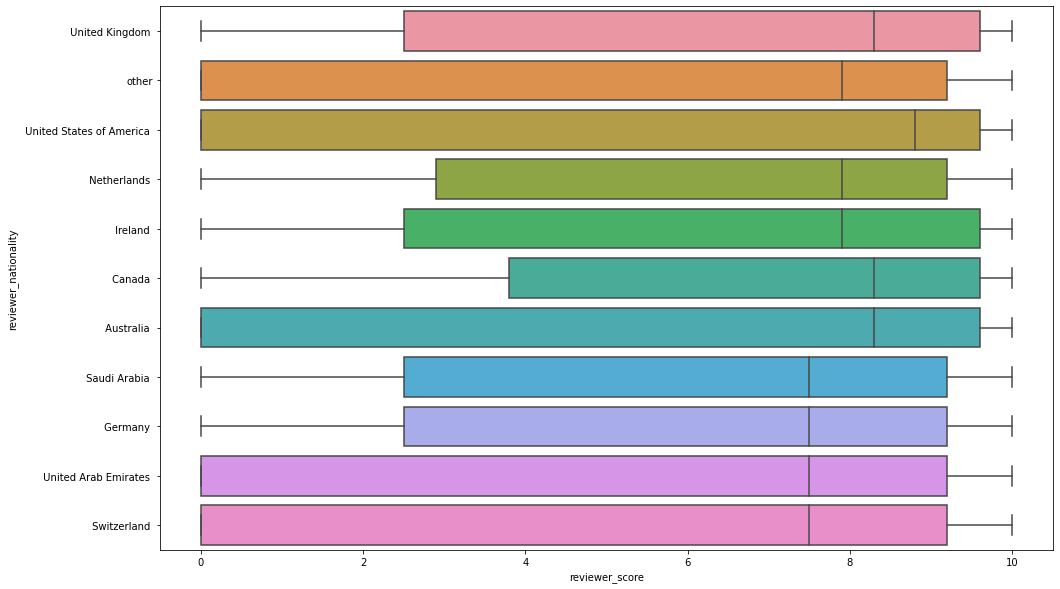

In [24]:
# Выделим десять лидирующих национальностей:

nationality10 = data['reviewer_nationality'].value_counts().nlargest(10)

data['reviewer_nationality'] = data['reviewer_nationality'].apply(
    lambda x: x if x in nationality10 else 'other')

fig = plt.figure(figsize = (16,10))
barplot = sns.boxplot(
    data = data, x = 'reviewer_score',
    y = 'reviewer_nationality', orient = 'h')

In [25]:
# Кодируем признаки методом OneHotEncoding:

data = pd.get_dummies(data, columns = ['reviewer_nationality'])

4.3. Иследуем признак 'review_date'. Приведем дату отзыва к формату datetime.
Создадим новые числовые признаки:

***'review_year'*** - год;  
***'review_month'*** - месяц;  
***'review_quarter'*** - квартал;  
***'review_season'*** - сезон, в котором рецензент разместил соответствующий отзыв

In [26]:
# Приведем дату отзыва к формату datetime:

data['review_date'] = pd.to_datetime(data['review_date']).dt.date

# Выделим год, месяц, квартал из даты отзыва:

data['review_year'] = pd.to_datetime(data['review_date']).dt.year
data['review_month'] = pd.to_datetime(data['review_date']).dt.month
data['review_quarter'] = pd.to_datetime(data['review_date']).dt.quarter

# Создание нового признака 'review_season':

data['review_season'] = data['review_month']

def get_season(month):
        
    if month in list(range(3,6)):
        return 'spring'
    
    if month in list(range(6,9)):
        return 'summer'
    
    if month in list(range(9,12)):
        return 'autumn'
    
    else:
        return 'winter'

data['review_season'] = data['review_season'].apply(get_season)

# Кодируем признак методом OneHotEncoding:

data = pd.get_dummies(data, columns=['review_season'])

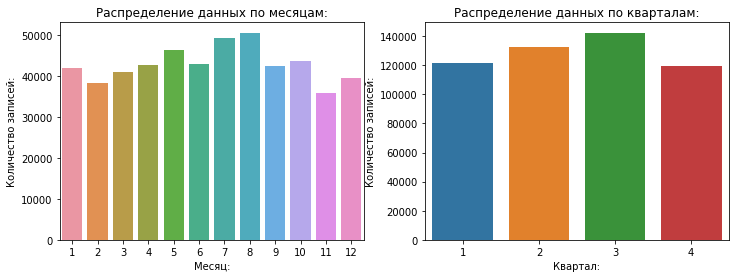

In [27]:
# Выделим сезонность оценок:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.countplot(data['review_month'], ax=axes[0]);
axes[0].set(xlabel='Месяц:', ylabel='Количество записей:')
axes[0].set_title('Распределение данных по месяцам:')

sns.countplot(data['review_quarter'],  ax=axes[1]);
axes[1].set(xlabel='Квартал:', ylabel='Количество записей:')
axes[1].set_title('Распределение данных по кварталам:')
fig.show()

4.4 Иследуем признак 'tags' и создадим новый числовой признак ***'nights'*** - количество ночей в отеле:

In [28]:
data['tags'] = data['tags'].apply(
    lambda x: x.replace("[' ", "").replace(" ']", "").split(" ', ' "))

def get_night(arg):
    
    for tag in arg:
        if 'Stayed' in tag:
            return int(tag.split()[1])
            
# Создание нового признака 'nights':
data['nights'] = data['tags'].apply(get_night)

# Заменим пропуски в признаке медианой:
data['nights'] = data['nights'].fillna(data.nights.median())

4.5 Иследуем признак 'tags' и создадим новый числовой признак ***'type_trip'*** - тип поездки:

In [29]:
# Создание нового признака 'type_trip':

data['type_trip'] = data['tags'].apply(
    lambda x: 1 if 'Business' in x else 0)

4.6 Иследуем признак 'tags' и создадим новый признак ***'type_of_travelers'*** - тип путешественников:

In [30]:
def set_why_stayed(value):
    
    if 'Group' in  value:
        return 'Group'
    if 'Couple' in value:
        return 'Couple'  
    if 'Solo traveler' in value:
        return 'Solo traveler'
    if 'Family with young children' in value:
        return 'Family with young children'
    if 'Family with older children' in value:
        return 'Family with older children' 
    return np.nan

# Создание нового признака 'type_of_travelers':

data['type_of_travelers'] = data['tags'].apply(set_why_stayed)
data['type_of_travelers'] = data['type_of_travelers'].fillna(
    data['type_of_travelers'].mode().iat[0])

# Кодируем признак методом OneHotEncoding:

data = pd.get_dummies(data, columns=['type_of_travelers'])

4.7 Иследуем признак 'tags' и создадим новый признак ***'type_of_apartment'*** - тип проживания:

In [31]:
def get_room(arg):
    
    for tag in arg:
        if 'Room' in tag:
            return tag.strip()
    return 'Unknown'
            
# Создание нового признака 'type_of_apartment':

data['type_of_apartment'] = data['tags'].apply(get_room)

4.8 Иследуем признак 'days_since_review' выделим числа:

In [32]:
data['days_since_review'] = data['days_since_review'].apply(
    lambda x: int(x.split()[0]))

4.9 Иследуем признак 'negative_review' и создадим числовой признак ***'is_negative'*** - отрицательные отзывы, которые не имеют отрицательного значения:

In [33]:
# Создание нового признака 'is_negative':

data['is_negative'] = data['negative_review'].apply(
    lambda x: 0 if x == 'No Negative' else 1)

4.10 Иследуем признак 'positive_review' и создадим числовой признак ***'is_positive'*** - положительные отзывы, которые не имеют положительного значения:

In [34]:
# Создание нового признака 'is_positive':

data['is_positive'] = data['positive_review'].apply(
    lambda x: 0 if x =='No Positive' else 1)

### **Вывод:** в результате проведенных исследований существующих признаков удалось создать ряд дополнительных признаков.

## **5. Отбор признаков:**

5.1. Определим в данных признаки, которые не будут участвовать в исследовании:

In [35]:
# Удаляем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет,
# просто выберим их и удалим:

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 49 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     515738 non-null  int64  
 1   average_score                                    515738 non-null  float64
 2   review_total_negative_word_counts                515738 non-null  int64  
 3   total_number_of_reviews                          515738 non-null  int64  
 4   review_total_positive_word_counts                515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given       515738 non-null  int64  
 6   days_since_review                                515738 non-null  int64  
 7   sample                                           515738 non-null  int64  
 8   reviewer_score                                   515738 non-null  float64
 9   hotel_city_coun

5.2. Для визуализации корреляций воспользуемся тепловой матрицей:

Text(0.5, 1.0, 'Тепловая карта корреляции числовых признаков:')

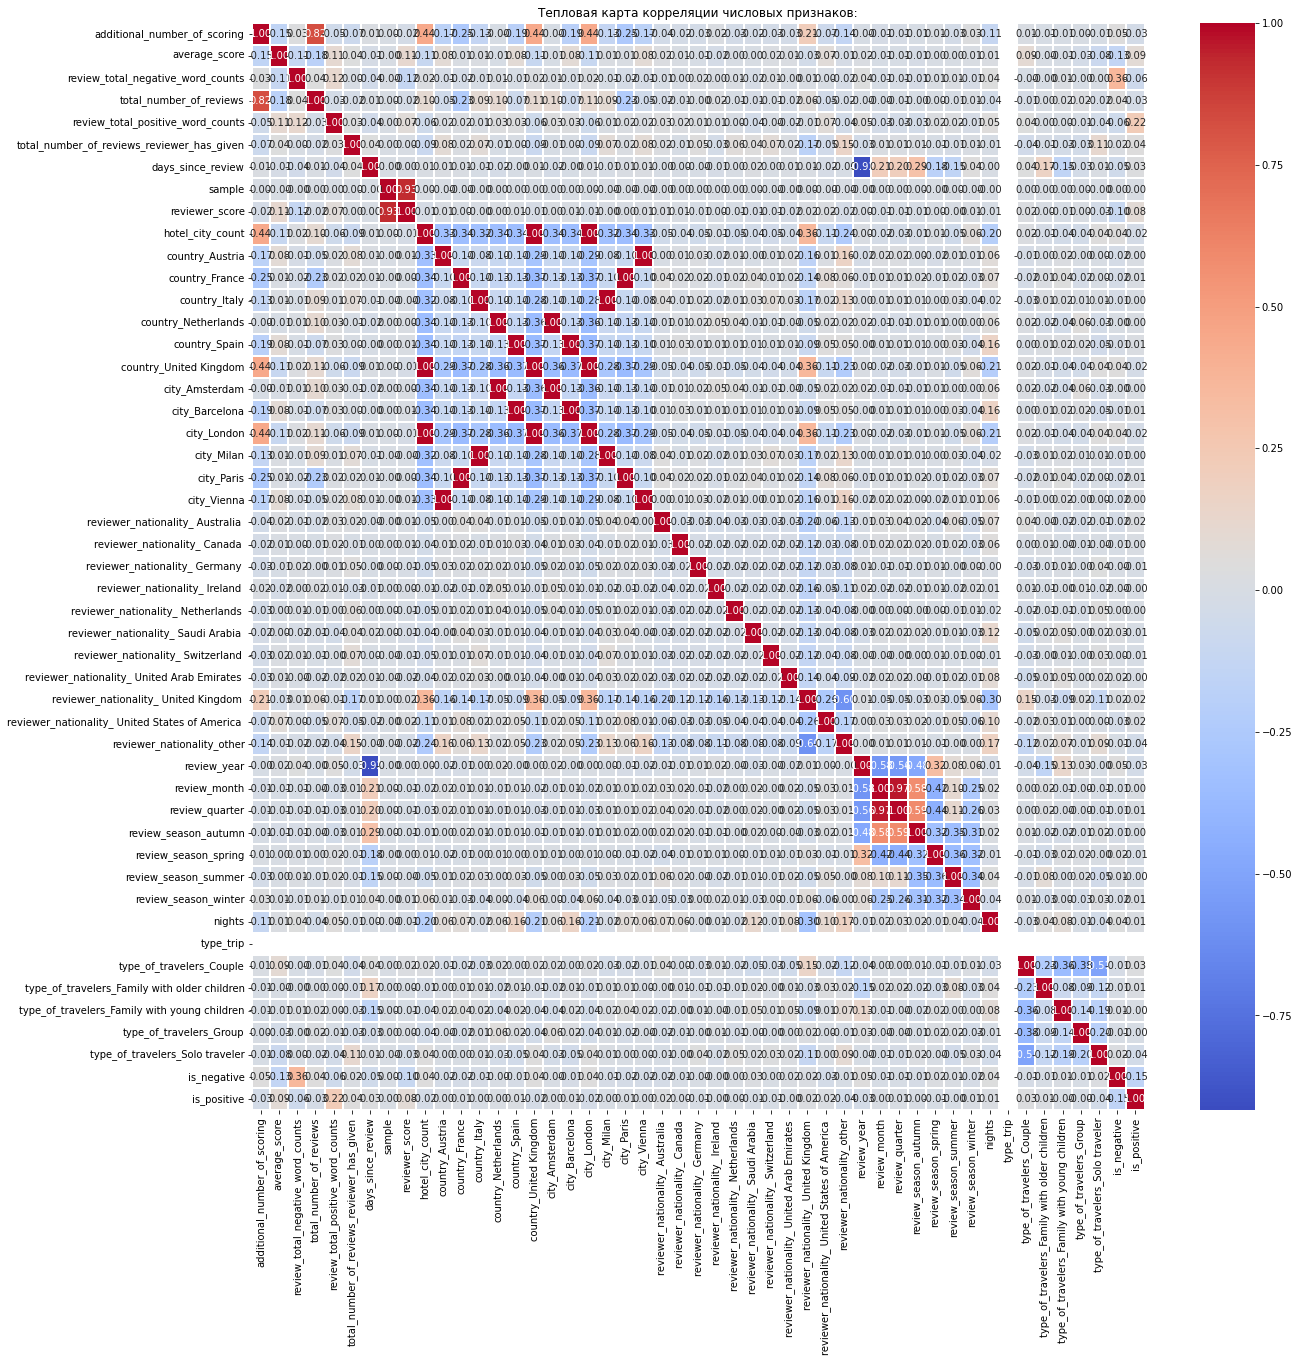

In [37]:
fig = plt.figure(figsize = (20,20))
ax = sns.heatmap(data.corr(), fmt='.2f', linewidths=.1,
                 cmap='coolwarm', annot=True)
ax.set_title('Тепловая карта корреляции числовых признаков:')

In [38]:
# Теперь выделим тестовую часть:

train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

### **Вывод:** мультиколлинеарными являются признаки days_since_review и review_year, следовательно один из них удалим.

In [39]:
# Удаляем мультиколлинеарный признак

data.drop('days_since_review', axis=1, inplace=True)

## **6. Обучение модели**

In [40]:
# Воспользуемся специальной функцие train_test_split
# для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size):

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [41]:
# Проверяем:

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 48), (386803, 48), (386803, 47), (309442, 47), (77361, 47))

In [42]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели:

from sklearn.ensemble import RandomForestRegressor

# инструменты для оценки точности модели:

from sklearn import metrics

In [43]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ):

model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [44]:
# Обучаем модель на тестовом наборе данных:

model.fit(X_train, y_train)

# Используем обученную модель для предсказания
# рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred:

y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [45]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test),
# и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает
# среднее отклонение предсказанных значений от фактических.

print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9417638455084725


<AxesSubplot:>

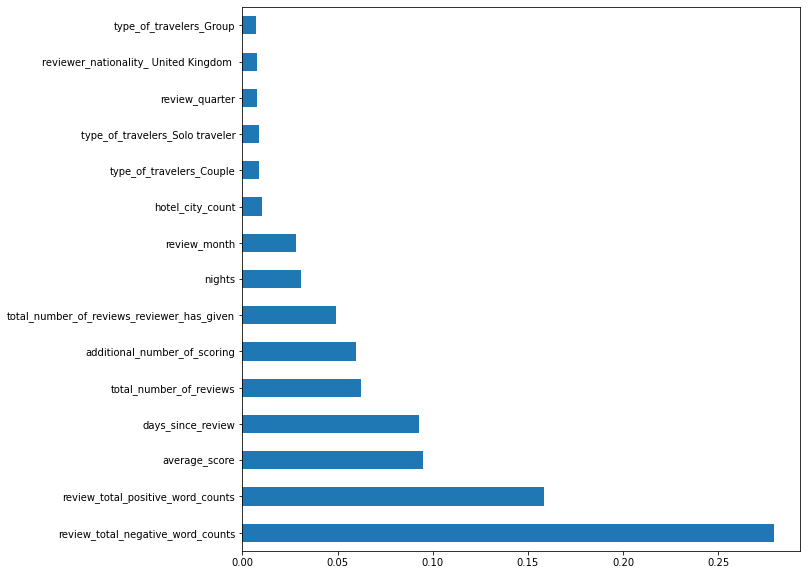

In [46]:
# в RandomForestRegressor есть возможность вывести
# самые важные признаки для модели:

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [47]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,hotel_city_count,country_Austria,...,review_season_winter,nights,type_trip,type_of_travelers_Couple,type_of_travelers_Family with older children,type_of_travelers_Family with young children,type_of_travelers_Group,type_of_travelers_Solo traveler,is_negative,is_positive
128681,710,7.9,96,6511,17,1,197,0.0,59928,0,...,1,4.0,0,0,0,1,0,0,1,1
118339,827,8.6,5,4593,29,6,218,0.0,57214,0,...,1,3.0,0,1,0,0,0,0,1,1
12994,550,8.8,18,4097,5,9,172,0.0,57214,0,...,1,2.0,0,1,0,0,0,0,1,1
48691,989,8.4,0,4660,24,1,201,0.0,262301,0,...,1,1.0,0,1,0,0,0,0,0,1
64900,15,8.2,16,139,8,1,66,0.0,60149,0,...,0,2.0,0,1,0,0,0,0,1,1
124324,335,9.0,0,1062,10,1,485,0.0,262301,0,...,0,9.0,0,0,0,0,0,1,0,1
102191,296,7.8,7,943,8,1,226,0.0,262301,0,...,1,1.0,0,1,0,0,0,0,1,1
55907,33,8.8,103,234,96,1,157,0.0,59928,0,...,1,4.0,0,1,0,0,0,0,1,1
44489,178,8.8,0,1337,3,2,576,0.0,59928,0,...,1,3.0,0,0,1,0,0,0,0,1
59101,187,7.6,0,830,4,1,632,0.0,262301,0,...,0,1.0,0,0,0,0,0,1,0,1


In [48]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [49]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [50]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [51]:
predict_submission

array([8.574, 6.963, 7.789, ..., 7.878, 9.44 , 7.095])

In [52]:
list(sample_submission)

['reviewer_score', 'id']

In [53]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.574,488440
1,6.963,274649
2,7.789,374688
3,9.520,404352
4,9.601,451596
5,8.730,302161
6,8.292,317079
7,7.534,13963
8,8.710,159785
9,8.020,195089


### **Вывод:** в результате проведенной работы нам удалось изменить результат метрики MAPE. 